In [67]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest

from pyod.models.iforest import IForest


plt.rcParams["figure.figsize"] = (12,10)

In [118]:
X = pd.read_csv('../data/card_transactions.csv')

In [6]:
X.head()

,customer_id,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc
0,tGEg8fT2eCgVxdwS,9.298409,107.60,0.000000,0.00,0.909091,107.6,0.909091,0.000000,0.818182,0.000000,0,10,1000.0,11,89.868853,89.711672,0.428571
1,stEDu20sSKOXomjg,52.666422,150.30,0.000000,0.00,1.000000,150.3,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,6,54.722514,82.955180,0.000000
2,CEB2blrN3b88GsRe,1360.795674,0.00,462.861443,0.00,1.000000,0.0,0.000000,0.000000,0.000000,0.272727,6,0,1500.0,11,303.031979,443.781316,0.000000
3,0N0eBl8ySaZThxKE,2021.641161,363.18,0.000000,363.18,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,0,13,2000.0,12,704.240770,795.859808,0.000000
4,6NLauoHUwtwOv4Wy,22.322374,95.00,1162.045833,95.00,0.363636,0.0,0.083333,0.083333,0.000000,0.166667,3,1,2500.0,12,4094.261427,40.142262,0.000000


In [7]:
X.groupby('customer_id').size().value_counts()

1    8500
dtype: int64

In [9]:
X['purchases-balance'] = X['balance_account'] - X['purchases_amount']

In [26]:
corr=X.corr()
corr_high = corr.applymap(lambda x: round(x,2) if x > 0.8 else 0)

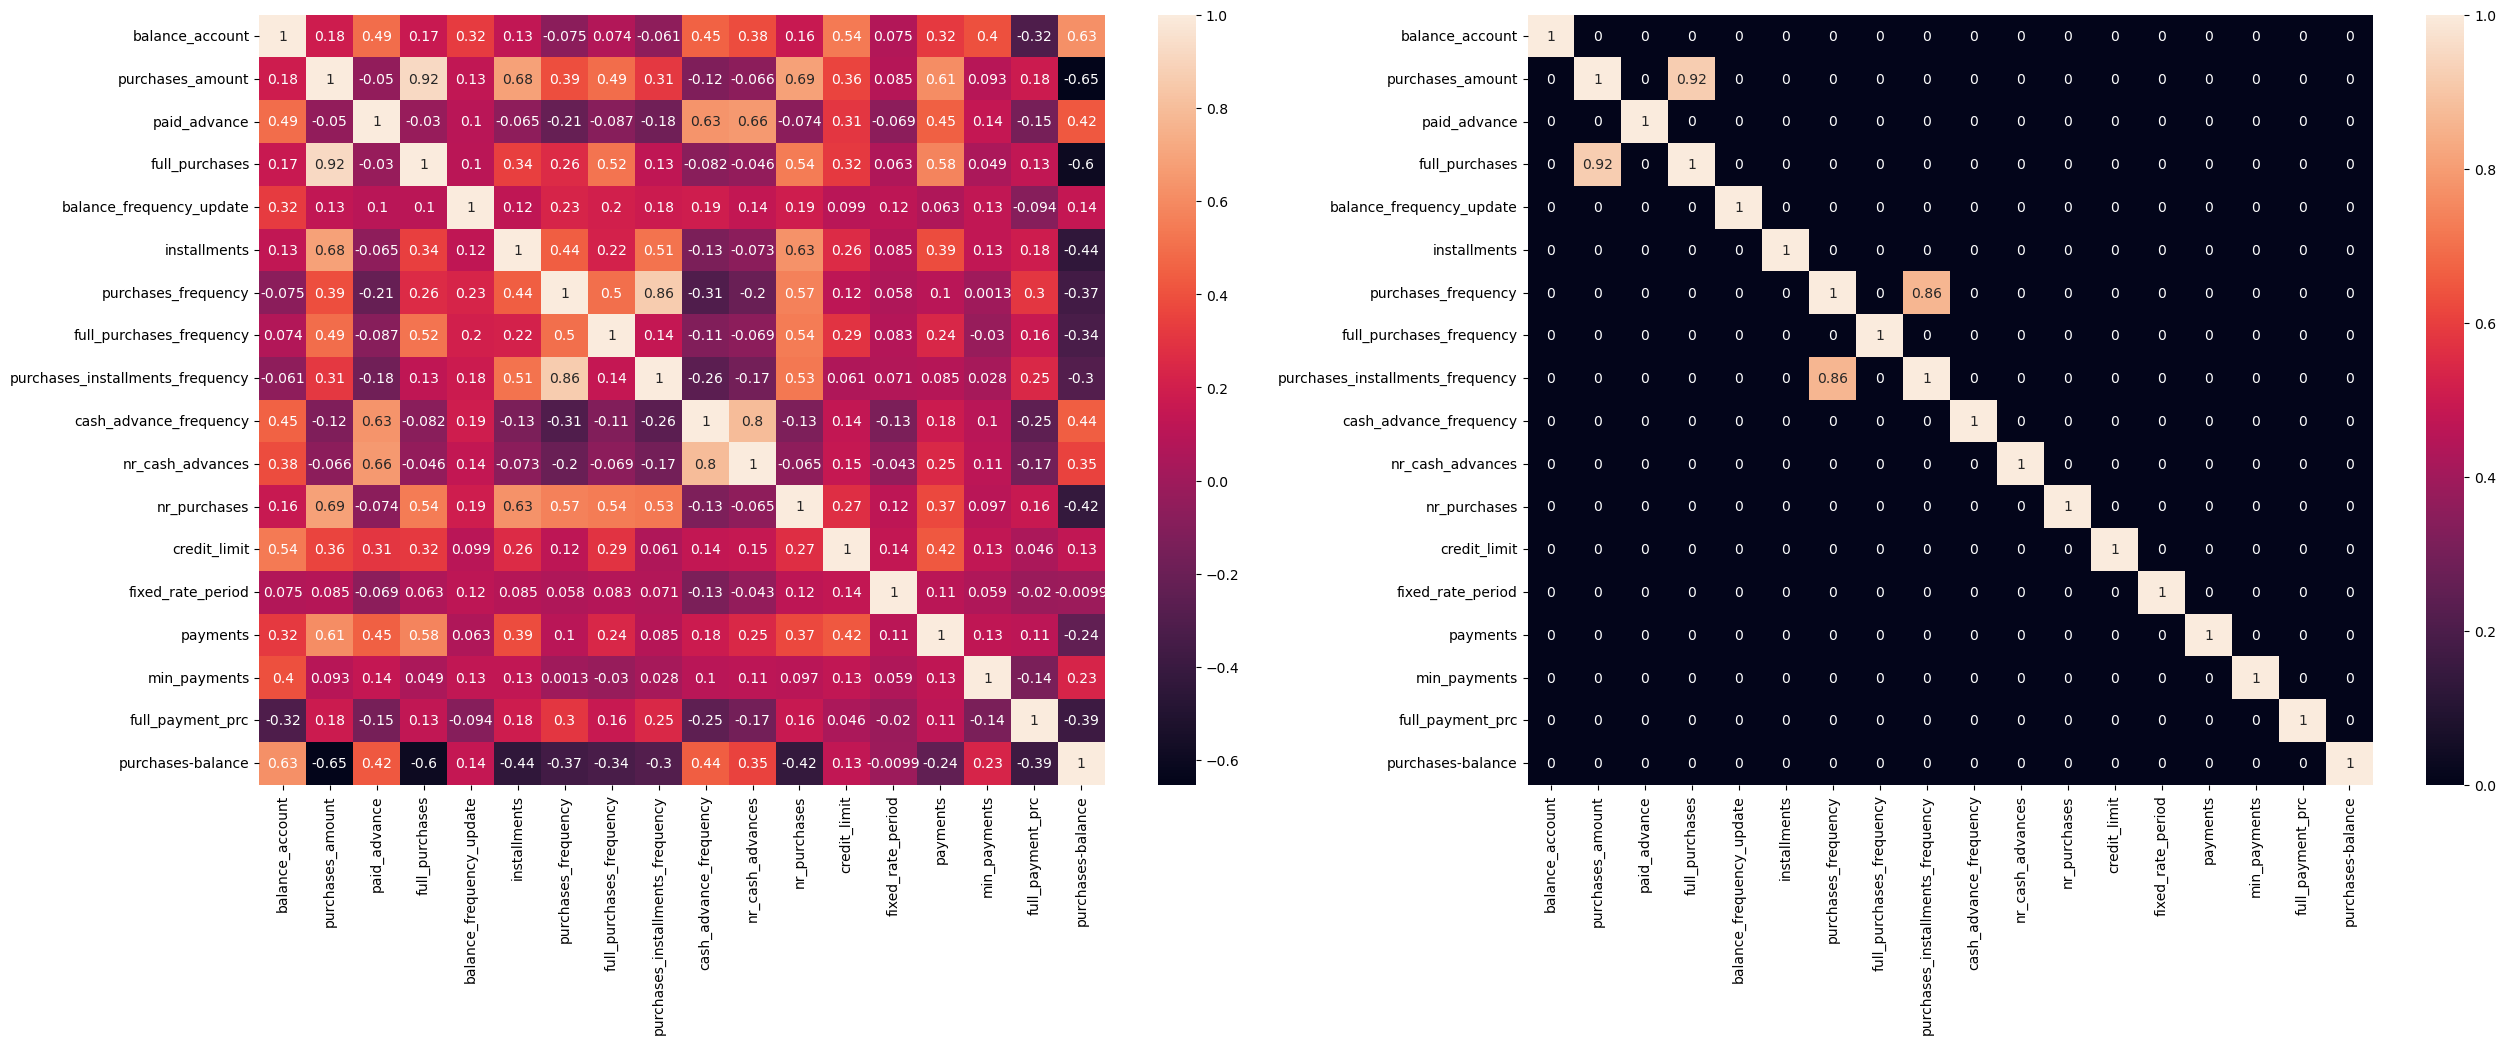

In [29]:
fig, axes = plt.subplots(1,2,figsize=(30,10));
sns.heatmap(corr, annot = True, ax=axes[0]);
sns.heatmap(corr_high, annot = True, ax=axes[1]);

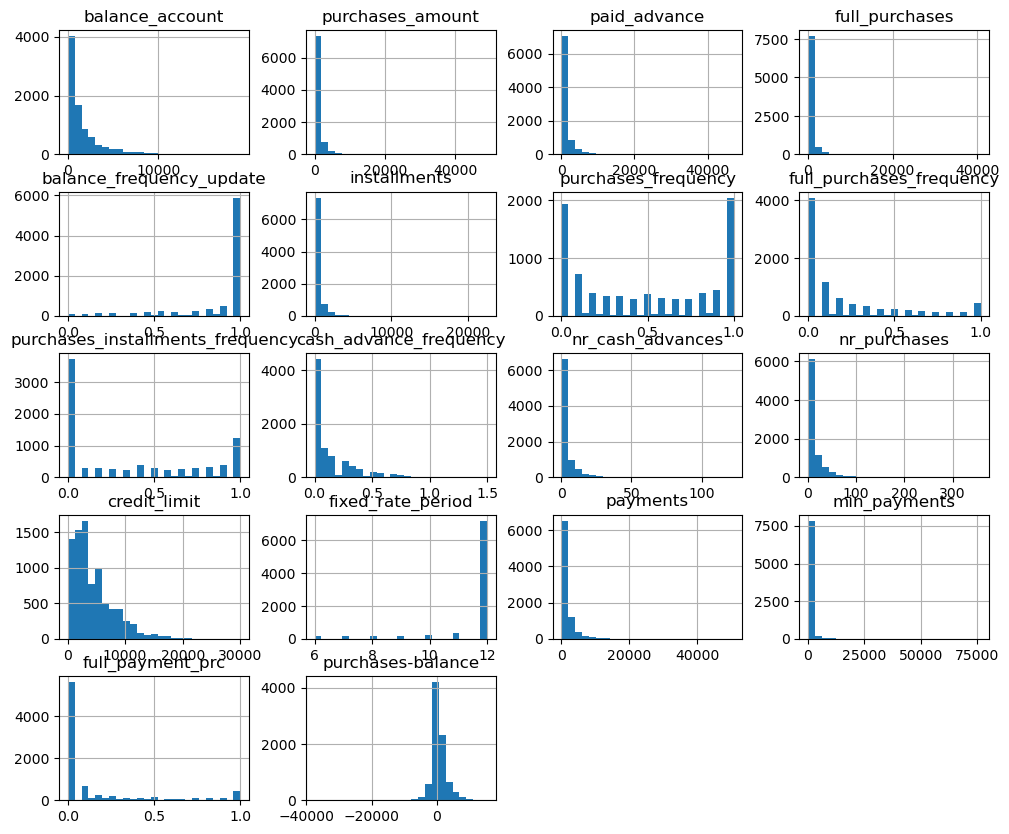

In [33]:
X.hist(bins=25);

In [47]:
X['installments'].max()

22500.0

In [49]:
X.sort_values(by='min_payments', ascending=False)

,customer_id,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc,purchases-balance
6181,5blZoSGJpSzUJOxn,10571.411070,7739.48,0.000000,0.0,1.000000,7739.48,1.000000,0.000000,1.0,0.000000,0,44,8000.0,12,2688.447014,76406.20752,0.0,2831.931070
2377,BpMagbgfQHoKQnqt,9024.812044,0.00,2750.442399,0.0,1.000000,0.00,0.000000,0.000000,0.0,0.083333,2,0,9000.0,12,302.484224,61031.61860,0.0,9024.812044
5057,xdQ0rwdsPjq2F95K,4628.109931,912.54,0.000000,0.0,1.000000,912.54,1.000000,0.000000,1.0,0.000000,0,21,5000.0,12,3746.305759,56370.04117,0.0,3715.569931
6134,x9jOtrKn6aW4zyL5,4976.028578,900.87,0.000000,0.0,1.000000,900.87,1.000000,0.000000,1.0,0.000000,0,162,5500.0,12,92.865469,50260.75947,0.0,4075.158578
3072,KBsvvnCbAW7X0ufM,8038.893195,0.00,197.915586,0.0,1.000000,0.00,0.000000,0.000000,0.0,0.166667,8,0,9000.0,12,3569.182969,43132.72823,0.0,8038.893195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,hFGLaz0A3lTtvK43,212.306148,0.70,1922.593600,0.7,0.181818,0.00,0.083333,0.083333,0.0,0.166667,3,1,3500.0,12,0.000000,NaN,0.0,211.606148
8422,KBWRrBwKqKvGKzjv,253.083620,0.00,1654.916972,0.0,0.181818,0.00,0.000000,0.000000,0.0,0.083333,1,0,1800.0,12,0.000000,NaN,0.0,253.083620
8460,zVzc7CzWYPj6QN71,147.418569,1074.00,0.000000,1074.0,0.181818,0.00,0.083333,0.083333,0.0,0.000000,0,2,5500.0,12,0.000000,NaN,0.0,-926.581431
8490,qiNQQyNu3YM9PRwP,0.000000,232.20,0.000000,0.0,0.000000,232.20,1.000000,0.000000,1.0,0.000000,0,12,1500.0,12,415.603589,NaN,0.0,-232.200000


In [81]:
# Isolation Forest for outliers

outliers_IF = IsolationForest(n_estimators=100, contamination=0.01)


outliers_IF.fit(X.drop(columns=['customer_id']).dropna())

/home/agustin/anaconda3/envs/MLG/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01)

In [103]:
X_clean = X.dropna().drop(columns=['customer_id'])

In [104]:
outliers_IF.predict(X_clean)

array([1, 1, 1, ..., 1, 1, 1])

In [105]:
outliers_IF_PYOD = IForest()

In [106]:
outliers_IF_PYOD.fit(X_clean)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [107]:
feature_importance = outliers_IF_PYOD.feature_importances_

In [96]:
feature_importance.sort()

In [97]:
feature_importance[::-1]

array([0.07113222, 0.06361047, 0.0614865 , 0.06088367, 0.05783681,
       0.05695239, 0.05566827, 0.05483436, 0.05376988, 0.05272453,
       0.05033379, 0.04987289, 0.04957252, 0.04899725, 0.04612802,
       0.04517071, 0.04513969, 0.03908233, 0.0368037 ])

In [98]:
score = outliers_IF_PYOD.decision_function(X_clean)

/home/agustin/anaconda3/envs/MLG/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [99]:
#X_clean['score'] = score

In [108]:
X_clean

,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc,purchases-balance
0,9.298409,107.60,0.000000,0.00,0.909091,107.60,0.909091,0.000000,0.818182,0.000000,0,10,1000.0,11,89.868853,89.711672,0.428571,-98.301591
1,52.666422,150.30,0.000000,0.00,1.000000,150.30,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,6,54.722514,82.955180,0.000000,-97.633578
2,1360.795674,0.00,462.861443,0.00,1.000000,0.00,0.000000,0.000000,0.000000,0.272727,6,0,1500.0,11,303.031979,443.781316,0.000000,1360.795674
3,2021.641161,363.18,0.000000,363.18,1.000000,0.00,1.000000,1.000000,0.000000,0.000000,0,13,2000.0,12,704.240770,795.859808,0.000000,1658.461161
4,22.322374,95.00,1162.045833,95.00,0.363636,0.00,0.083333,0.083333,0.000000,0.166667,3,1,2500.0,12,4094.261427,40.142262,0.000000,-72.677626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8494,2707.058356,2018.13,0.000000,1545.23,1.000000,472.90,0.750000,0.250000,0.666667,0.000000,0,26,7000.0,12,2575.541309,661.487315,0.000000,688.928356
8495,1127.607606,0.00,271.093275,0.00,1.000000,0.00,0.000000,0.000000,0.000000,0.083333,1,0,8500.0,12,662.387331,260.277533,0.000000,1127.607606
8496,21.409828,149.71,0.000000,0.00,1.000000,149.71,0.916667,0.000000,0.916667,0.000000,0,11,1500.0,12,141.974905,150.500248,0.166667,-128.300172
8498,1646.384530,1047.34,146.650389,1047.34,1.000000,0.00,0.583333,0.583333,0.000000,0.166667,2,51,3000.0,12,462.848132,497.408854,0.000000,599.044530


<AxesSubplot:>

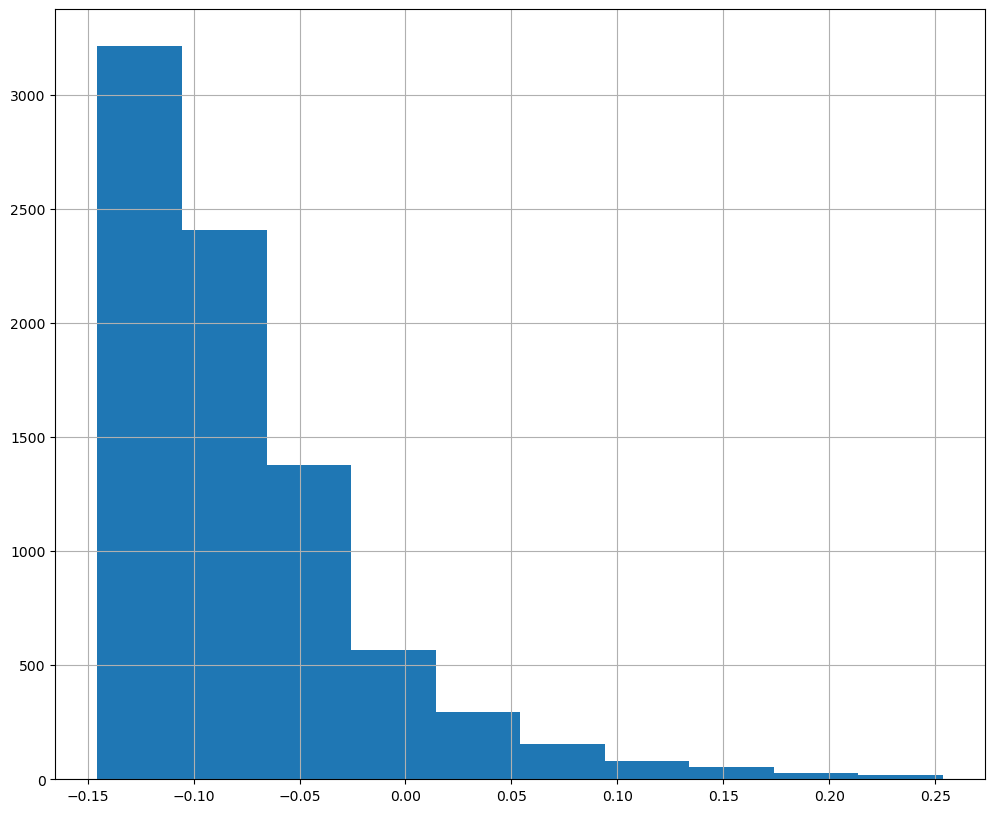

In [101]:
X_clean['score'].hist()

array([1, 1, 1, ..., 1, 1, 1])

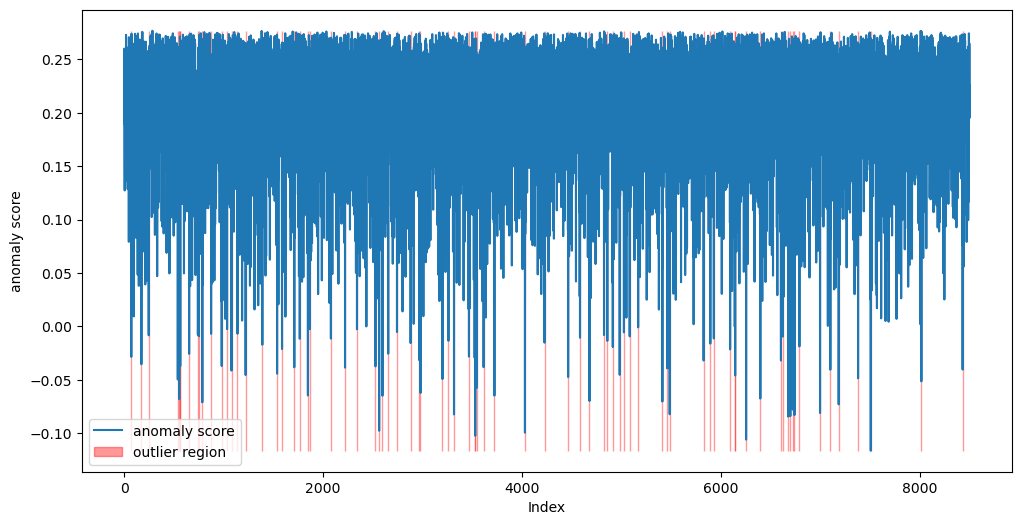

In [110]:
xx = np.linspace(X_clean.index.min(), X_clean.index.max(), len(X_clean)).reshape(-1,1)
anomaly_score = outliers_IF.decision_function(X_clean)
outlier = outliers_IF.predict(X_clean)
plt.figure(figsize=(12, 6))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Index');
outlier

In [117]:
pd.Series(outlier).value_counts()

 1    8119
-1      82
dtype: int64

(array([  82.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8119.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

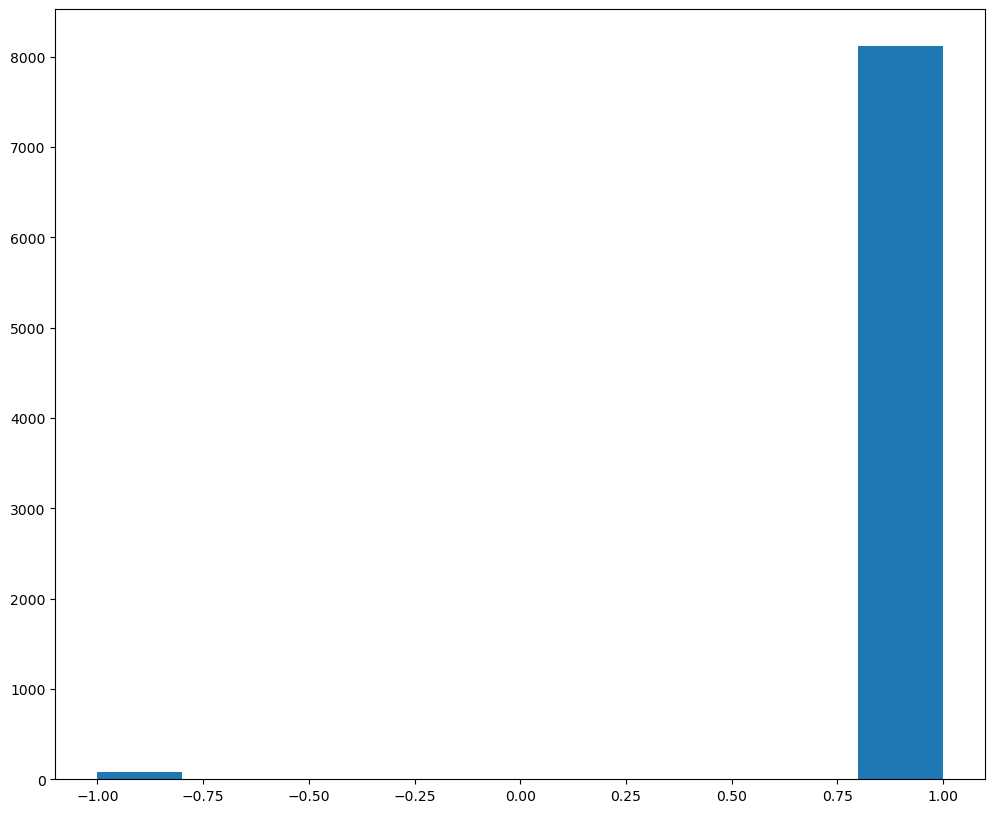

In [113]:
plt.hist(outlier)